# 🧮 Building a mini optimizer library

In the following example an `optax`-like mini-library is built using `pytreeclass`. The optimizer library is then used to train a simple neural network.

In [1]:
!pip install pytreeclass --quiet

## Imports

In [2]:
import jax
import jax.numpy as jnp
import pytreeclass as pytc
from typing import Any, TypeVar, Generic, Callable
import abc
import matplotlib.pyplot as plt

PyTree = Any
T = TypeVar("T")

## Template

In [3]:
class GradientTransformation(pytc.TreeClass, Generic[T]):
    # TreeClass inherits from `abc.ABC`
    # following the same pattern as `optax` optimizers
    # https://github.com/deepmind/optax/blob/fc5de3d3951c4dfd87513c6426e30baf505d89ae/optax/_src/base.py#L85
    @abc.abstractclassmethod
    def update(self, _: T) -> tuple[T, "GradientTransformation"]:
        pass

## Optimizer functions

In [4]:
def moment_update(grads, moments, *, beta: float, order: int):
    def moment_step(grad, moment):
        return beta * moment + (1 - beta) * (grad**order)

    return jax.tree_map(moment_step, grads, moments)


def debias_update(moments, *, beta: float, count: int):
    def debias_step(moment):
        return moment / (1 - beta**count)

    return jax.tree_map(debias_step, moments)


def ema(decay_rate: float, debias: float = True) -> GradientTransformation:
    """Exponential moving average

    Args:
        decay_rate: The decay rate of the moving average.
        debias: Whether to debias the moving average.
    """

    class EMA(GradientTransformation):
        def __init__(self, tree):
            self.state = jax.tree_map(jnp.zeros_like, tree)
            self.count = 0

        def _update(self, grads: T) -> T:
            self.count += 1
            self.state = moment_update(grads, self.state, beta=decay_rate, order=1)
            if debias:
                return debias_update(self.state, beta=decay_rate, count=self.count)
            return self.state

        def update(self, grads: T) -> tuple[T, "EMA"]:
            return self.at["_update"](grads)

    return EMA


def adam(
    *,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
) -> GradientTransformation:
    """Adam optimizer

    Args:
        beta1: The decay rate of the first moment.
        beta2: The decay rate of the second moment.
        eps: A small value to prevent division by zero.

    Note:
        Kingma et al, 2014: https://arxiv.org/abs/1412.6980
    """

    class Adam(GradientTransformation):
        def __init__(self, tree):
            self.mu = jax.tree_map(jnp.zeros_like, tree)
            self.nu = jax.tree_map(jnp.zeros_like, tree)
            self.count = 0

        def _update(self, grads: T) -> T:
            self.count += 1
            self.mu = moment_update(grads, self.mu, beta=beta1, order=1)
            self.nu = moment_update(grads, self.nu, beta=beta2, order=2)
            mu_hat = debias_update(self.mu, beta=beta1, count=self.count)
            nu_hat = debias_update(self.nu, beta=beta2, count=self.count)
            return jax.tree_map(
                lambda mu, nu: mu / (jnp.sqrt(nu) + eps), mu_hat, nu_hat
            )

        def update(self, grads: T) -> tuple[T, "Adam"]:
            # since self._update mutates the state, we need to use self.at
            # to return the method value and the mutated state
            return self.at["_update"](grads)

    return Adam


def scale(rate_func: Callable[[int], float]) -> GradientTransformation:
    """Scale the gradients by a scheduler function"""

    class Scale(GradientTransformation):
        def __init__(self, _=None):
            self.count = 0
            self.rate = rate_func(self.count)

        def _update(self, grads: T) -> T:
            self.count += 1
            self.rate = rate_func(self.count)
            return jax.tree_map(lambda x: x * self.rate, grads)

        def update(self, grads: T) -> tuple[T, "Scale"]:
            return self.at["_update"](grads)

    return Scale


def chain(
    *transformations: tuple[GradientTransformation, ...]
) -> GradientTransformation:
    """Chain multiple transformations together similar to `optax.chain`"""

    class Chain(GradientTransformation):
        def __init__(self, tree):
            self.transformations = tuple(T(tree) for T in transformations)

        def _update(self, grads: T) -> T:
            state = []
            for transformation in self.transformations:
                grads, optim_state = transformation.update(grads)
                state += [optim_state]
            self.transformations = tuple(state)
            return grads

        def update(self, grads: T) -> tuple[T, "Chain"]:
            return self.at["_update"](grads)

    return Chain

## Construct a fully connected neural network

In [5]:
class FNN(pytc.TreeClass):
    def __init__(self):
        self.w1 = jax.random.normal(jax.random.PRNGKey(0), [1, 10])
        self.b1 = jnp.zeros([10], dtype=jnp.float32)
        self.w2 = jax.random.normal(jax.random.PRNGKey(1), [10, 1])
        self.b2 = jnp.zeros([1], dtype=jnp.float32)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x @ self.w1 + self.b1
        x = jax.nn.relu(x)
        x = x @ self.w2 + self.b2
        return x

## Train function

Epoch=1000	Loss: 1.322e-04	 Gradient scaler: -1.000e-02
Epoch=2000	Loss: 8.230e-05	 Gradient scaler: -1.000e-03
Epoch=3000	Loss: 8.062e-05	 Gradient scaler: -1.000e-03
Epoch=4000	Loss: 7.908e-05	 Gradient scaler: -1.000e-03
Epoch=5000	Loss: 7.730e-05	 Gradient scaler: -1.000e-04
Epoch=6000	Loss: 7.702e-05	 Gradient scaler: -1.000e-04
Epoch=7000	Loss: 7.657e-05	 Gradient scaler: -1.000e-04
Epoch=8000	Loss: 7.584e-05	 Gradient scaler: -1.000e-04
Epoch=9000	Loss: 7.464e-05	 Gradient scaler: -1.000e-04
Epoch=10000	Loss: 7.271e-05	 Gradient scaler: -1.000e-04


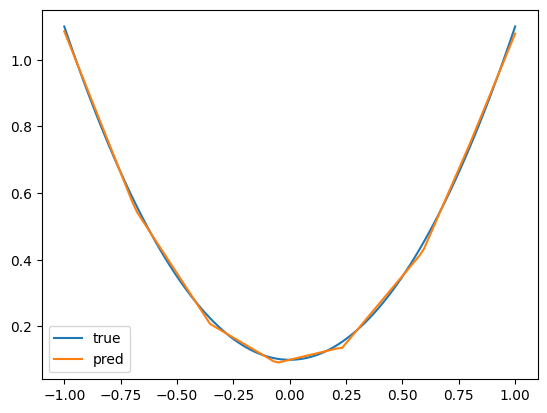

In [6]:
def scheduler(count: int) -> float:
    # build a scheduler function
    return jnp.where(count < 2_000, -1e-2, jnp.where(count < 5_000, -1e-3, -1e-4))


fnn = FNN()
optim = chain(adam(), scale(scheduler))
optim_state = optim(fnn)


def loss_func(fnn: FNN, x: jax.Array, y: jax.Array) -> jax.Array:
    return jnp.mean((fnn(x) - y) ** 2)


@jax.jit
def train_step(fnn, optim_state, x, y):
    grads = jax.grad(loss_func)(fnn, x, y)

    grads, optim_state = optim_state.update(grads)
    fnn = jax.tree_map(lambda p, g: p + g, fnn, grads)
    return fnn, optim_state


x = jnp.linspace(-1, 1, 100).reshape(-1, 1)
y = x**2 + 0.1

for i in range(1, 10_000 + 1):
    fnn, optim_state = train_step(fnn, optim_state, x, y)
    if i % 1_000 == 0:
        loss = loss_func(fnn, x, y)
        learning_rate = optim_state.transformations[1].rate
        print(
            f"Epoch={i:003d}\tLoss: {loss:.3e}\t Gradient scaler: {learning_rate:.3e}"
        )

plt.plot(x, y, label="true")
plt.plot(x, fnn(x), label="pred")
plt.legend()